PATH 関数　定義

In [58]:
CropDataset_path = "Crop_Data/TEST_tuning_40_Crop64" #色つけ対象データセット
original_image_path = "/a/yu-yamaoka/data/valid0724_2/" #patch前のデータセット
experiment_path = "/a/yu-yamaoka/Scientific_reports/Crop_Data/TEST_tuning_40_Crop64/experiment" #class label有

from cellpose import models, io
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import cv2

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
def img_to_cellpose(img_path, model_type= 'cyto', chan=[0,0], min_size=40, gpu_enabled = False, model_path = ""):
    """
    Input:
        img_path : (string) Image file PATH
    Return:
        mask : [width, height]
    Args:
        model_type : https://github.com/MouseLand/cellpose/blob/main/cellpose/models.py#L19~L20
        chan : https://github.com/MouseLand/cellpose/blob/main/cellpose/models.py#L209
        min_size : https://github.com/MouseLand/cellpose/blob/main/cellpose/models.py#L175
        gpu_enabled : Are u install cuda?
        model_path : FineTuning model Path
    """
    assert os.path.exists(img_path), ("image path is NOT exist")
    img = io.imread(img_path)
    
    # declare model
    if model_path != "":
        assert os.path.exists(model_path), ("model path is NOT exist")
        model = models.CellposeModel(gpu=gpu_enabled, pretrained_model=model_path)
        mask, _, _ = model.eval(img, diameter=None, channels=chan, min_size=min_size)
    else:
        model = models.Cellpose(gpu=gpu_enabled, model_type=model_type)
        mask, flows, styles, diams = model.eval(img, diameter=None, channels=chan, min_size=min_size)

    # save results so you can load in gui
    #io.masks_flows_to_seg(img, masks, flows, diams, img_path, chan)

    #save results as png
    #plt.imsave(img_path.replace(".png","CellposeMask.png"),masks)

    return mask

#mask画像をMaskRCNNが読み込めるデータセットにする。
def obj_detection(mask, class_id:int):
    """
    Input:
        mask : [width, height](ndarray), image data
        class_id : int , class id(ex : 1day -> 1)
    Return:
        mask : [width(int), height(int), object num(int)]
        cls_idxs : [nobject num(int)]
    """
    data = mask
    labels = []
    for label in np.unique(data):
        #: ラベルID==0は背景
        if label == 0:
            continue
        else:
            labels.append(label)

    if len(labels) == 0:
        #: 対象オブジェクトがない場合はNone
        return None, None
    else:
        mask = np.zeros((mask.shape)+(len(labels),), dtype=np.uint8)
        for n, label in enumerate(labels):
            mask[:, :, n] = np.uint8(data == label)
        cls_idxs = np.ones([mask.shape[-1]], dtype=np.int32) * class_id

        return mask, cls_idxs

512, 512, 3 -> n, 512, 512 -> 512, 512, 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

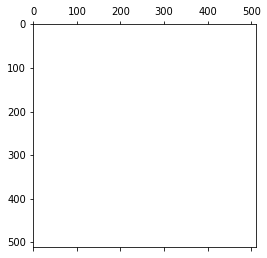

In [65]:
#Parameter Define
model_path = "/a/yu-yamaoka/Scientific_reports/tuning_model/yamaoka0428_3"
model_type = 'c'#https://github.com/MouseLand/cellpose/blob/main/cellpose/models.py#L19~L20
chan = [0,0] #チャンネル https://github.com/MouseLand/cellpose/blob/main/cellpose/models.py#L209
min_size = 40
days = ["0", "3", "5", "7"]

#color define rgb
red = [255, 0, 0]
blue = [0, 0, 255]
yellow = [255, 255, 0]
orange = [255, 150, 0]
cls_color = [red, blue, yellow, orange]


#main
savefolder = os.path.join(CropDataset_path, "piled")
if(os.path.exists(savefolder)==False):
    os.mkdir(savefolder)
    
cls_idxs = np.load(os.path.join(experiment_path, "class_ids.npy"), allow_pickle=True)
i = 0
    
for day in days:
    savefolderday = os.path.join(savefolder, "day"+ day)
    if(os.path.exists(savefolderday)==False):
        os.mkdir(savefolderday)
        
    original_image_daypath = os.path.join(original_image_path, day+"day", "image")
    original_image_filepaths = glob(original_image_daypath + "/*.png")
    
    for original_file in original_image_filepaths:
        final_img = np.ones((w, h, 3))
        
        mask = img_to_cellpose(original_file, model_type, chan, gpu_enabled = True, min_size=min_size, model_path=model_path)
        masks, _ = obj_detection(mask, class_id=0)
        mask_trans = masks.transpose(2, 0 ,1)
        
        #coloring
        for obj_mask in mask_trans:
            color_mask =  np.ones((w, h, 3))
            w, h = obj_mask.shape
            for k in range(w):
                for l in range(h):
                    if(mask[k, l]>=1):
                        color_mask[k, l, :] = cls_color[int(cls_idxs[i])]
            final_img += color_mask
            i += 1

        #save 
        #plt.matshow(final_img)
        savepath = os.path.join(savefolderday, os.path.basename(original_file))        
        cv2.imwrite(savepath, final_img)
            